## Classification - Cause of Fire
#### Names: Gal Getz, Moral Bootbool, Rotem Agmon, Kim Yekutiel 

Importing all the relevant libraries:

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import sqlite3
import warnings
import matplotlib
import shap
import optuna
import xgboost as xgb
%matplotlib inline
plt.style.use('ggplot')
warnings.filterwarnings('ignore')
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score


plt.style.use('ggplot')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (18,8)

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


loading the data frames:

In [3]:
# Imprt the data as data.csv
# The second one is Our extra data
data = pd.read_csv("data.csv")
# special_dates = pd.read_csv('american_special_dates.csv')
weather_data = pd.read_csv("Weather_Data.csv")

In [4]:
data.shape

(571425, 39)

In [5]:
state_region_mapping = {
    'CT': 'Northeast', 'ME': 'Northeast', 'MA': 'Northeast', 'NH': 'Northeast', 'RI': 'Northeast', 'VT': 'Northeast',
    'NJ': 'Northeast', 'NY': 'Northeast', 'PA': 'Northeast',
    'IL': 'Midwest', 'IN': 'Midwest', 'MI': 'Midwest', 'OH': 'Midwest', 'WI': 'Midwest', 'IA': 'Midwest', 'KS': 'Midwest',
    'MN': 'Midwest', 'MO': 'Midwest', 'NE': 'Midwest', 'ND': 'Midwest', 'SD': 'Midwest',
    'DE': 'South', 'FL': 'South', 'GA': 'South', 'MD': 'South', 'NC': 'South', 'SC': 'South', 'VA': 'South', 'DC': 'South', 'WV': 'South',
    'AL': 'South', 'KY': 'South', 'MS': 'South', 'TN': 'South',
    'AR': 'South', 'LA': 'South', 'OK': 'South', 'TX': 'South',
    'AZ': 'West', 'CO': 'West', 'ID': 'West', 'MT': 'West', 'NV': 'West', 'NM': 'West', 'UT': 'West', 'WY': 'West',
    'AK': 'Alaska', 'CA': 'West', 'HI': 'Hawaii', 'OR': 'West', 'WA': 'West', 'PR': 'Northeast',
}

### Preprocessing

First, we performed all the actions we could do on test + train together - dropping and adding columns.
* We dropped all columns we decided to remove primarily (why - in the PDF).

In [6]:
columns_to_drop =["OBJECTID", "Unnamed: 0","FOD_ID", "FPA_ID", "SOURCE_REPORTING_UNIT", "COUNTY", "FIPS_CODE","SOURCE_SYSTEM_TYPE","SOURCE_SYSTEM", "NWCG_REPORTING_AGENCY", "NWCG_REPORTING_UNIT_ID", "NWCG_REPORTING_UNIT_NAME", "LOCAL_FIRE_REPORT_ID", "LOCAL_INCIDENT_ID", "FIRE_CODE", "ICS_209_INCIDENT_NUMBER", "ICS_209_NAME", "MTBS_FIRE_NAME", "MTBS_ID", "COMPLEX_NAME", "Shape", "CONT_DATE", "CONT_DOY", "CONT_TIME", "OWNER_CODE", "FIPS_NAME", "DISCOVERY_TIME"]
data.drop(columns=columns_to_drop,inplace=True)

* Creating new features:

In [7]:
# if there exists a name - then 1, else 0.
data['FIRE_NAME'] = np.where(data['FIRE_NAME'].isna(), 1, 0)

# if there is "forest" involved in the fire - then 1, else 0.
data['FOREST_UNIT'] = np.where(data['SOURCE_REPORTING_UNIT_NAME'].str.lower().str.contains("forest"), 1, 0)

# time oriented features.
data['DATE'] = pd.to_datetime(data['FIRE_YEAR'].astype(str) + data['DISCOVERY_DOY'].astype(str), format='%Y%j')
data['DAY_OF_WEEK'] = data['DATE'].dt.dayofweek
data['DAY_OF_MONTH'] = data['DATE'].dt.day
data['MONTH'] = data['DATE'].dt.month
data['DAY_OF_WEEK_SIN'] = np.sin(2*np.pi*data['DAY_OF_WEEK']/7.0)
data['DAY_OF_WEEK_COS'] = np.cos(2*np.pi*data['DAY_OF_WEEK']/7.0)
data['MONTH_SIN'] = np.sin(2*np.pi*(data['MONTH'])/12.0)
data['MONTH_COS'] = np.cos(2*np.pi*(data['MONTH'])/12.0)

# special dates feature - if an American special date (e.t. July 4th) then 1, else 0.
# data = data.merge(special_dates, left_on=['DAY_OF_MONTH', 'MONTH'], right_on=['special_day', 'special_month'], how='left')
# data['IS_SPECIAL_DATE'] = data['special_day'].notna().astype(int)
data['IS_FOURTH_JULY_RANGE'] = (data['DAY_OF_MONTH'].isin([3, 4, 5])) & (data['MONTH'] == 7)

# Map each state to its corresponding region (out of 4)
data['REGION'] = data['STATE'].map(state_region_mapping)

# Add weather features (max temp + rain)
data = pd.merge(data, weather_data, on=['MONTH', 'STATE'])

# Change fire_size to log_fire_size
data['log_FIRE_SIZE'] = np.log(data['FIRE_SIZE'])

# Add INTERACTION feature between region and (lat,long):
for region in data['REGION'].unique():
    data[f'{region}_LONGITUDE'] = data['LONGITUDE'].where(data['REGION'] == region)
    data[f'{region}_LATITUDE'] = data['LATITUDE'].where(data['REGION'] == region)
    data[f'{region}_LONGITUDE'].fillna(0, inplace=True)
    data[f'{region}_LATITUDE'].fillna(0, inplace=True)

In [8]:
pd.set_option('display.max_columns', None)
data.head()

,SOURCE_REPORTING_UNIT_NAME,FIRE_NAME,FIRE_YEAR,DISCOVERY_DATE,DISCOVERY_DOY,STAT_CAUSE_DESCR,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_DESCR,STATE,FOREST_UNIT,DATE,DAY_OF_WEEK,DAY_OF_MONTH,MONTH,DAY_OF_WEEK_SIN,DAY_OF_WEEK_COS,MONTH_SIN,MONTH_COS,IS_FOURTH_JULY_RANGE,REGION,MAX_TEMP,PERCIPATATION,log_FIRE_SIZE,West_LONGITUDE,West_LATITUDE,Midwest_LONGITUDE,Midwest_LATITUDE,South_LONGITUDE,South_LATITUDE,Northeast_LONGITUDE,Northeast_LATITUDE,Alaska_LONGITUDE,Alaska_LATITUDE,Hawaii_LONGITUDE,Hawaii_LATITUDE
0,Fort Belknap Agency,0,2011,2455795.5,234,Miscellaneous,0.1,A,48.403300,-108.289600,PRIVATE,MT,0,2011-08-22,0,22,8,0.000000,1.000000,-0.866025,-0.5,False,West,80.9,1.2,-2.302585,-108.289600,48.403300,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Bitterroot National Forest,1,1994,2449575.5,223,Lightning,0.2,A,46.291667,-113.873333,USFS,MT,1,1994-08-11,3,11,8,0.433884,-0.900969,-0.866025,-0.5,False,West,80.9,1.2,-1.609438,-113.873333,46.291667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Kootenai National Forest,0,1995,2449930.5,213,Railroad,0.7,B,47.868333,-115.660000,STATE OR PRIVATE,MT,1,1995-08-01,1,1,8,0.781831,0.623490,-0.866025,-0.5,False,West,80.9,1.2,-0.356675,-115.660000,47.868333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Kootenai National Forest,0,2002,2452516.5,242,Lightning,0.1,A,48.145833,-115.800833,USFS,MT,1,2002-08-30,4,30,8,-0.433884,-0.900969,-0.866025,-0.5,False,West,80.9,1.2,-2.302585,-115.800833,48.145833,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Custer National Forest,0,2000,2451760.5,217,Lightning,0.1,A,45.209722,-106.001944,USFS,MT,1,2000-08-04,4,4,8,-0.433884,-0.900969,-0.866025,-0.5,False,West,80.9,1.2,-2.302585,-106.001944,45.209722,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Splitting to Train and Test


Splitting the data into train and test (and later on validation with cross validation).

In [9]:
X, y = data.drop('STAT_CAUSE_DESCR', axis=1), data['STAT_CAUSE_DESCR']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
train_data = pd.concat([X_train, y_train], axis=1)
test_data = pd.concat([X_test, y_test], axis=1)

### Before Modeling

* Scaling
* Dummies

In [10]:
final_features = ['FIRE_NAME', 'FIRE_YEAR', 'FIRE_SIZE', 'LATITUDE', 'LONGITUDE', 'REGION',
                  'FOREST_UNIT', 'MONTH_SIN', 'MONTH_COS', 'MAX_TEMP', 'PERCIPATATION', 'log_FIRE_SIZE',
                  'West_LONGITUDE', 'West_LATITUDE', 'Midwest_LONGITUDE', 'Midwest_LATITUDE', 'South_LONGITUDE',
                  'South_LATITUDE', 'Northeast_LONGITUDE', 'Northeast_LATITUDE', 'DISCOVERY_DOY', 'Alaska_LONGITUDE', 'Alaska_LATITUDE', 'Hawaii_LONGITUDE', 'Hawaii_LATITUDE',
                  'IS_FOURTH_JULY_RANGE', 'OWNER_DESCR']
final_features_set = set(final_features)

X_train = X_train[final_features]
X_test = X_test[final_features]

### Make dummies from State

In [11]:
X_train = pd.get_dummies(X_train, columns=['REGION', 'OWNER_DESCR'], drop_first=True)

encoded_columns = X_train.columns

X_test = pd.get_dummies(X_test)

X_test = X_test.reindex(columns=encoded_columns, fill_value=0)

X_test = X_test[encoded_columns]

In [12]:
columns_to_drop = set(X_test.columns) - set(encoded_columns)

X_test.drop(columns=columns_to_drop, inplace=True)

In [13]:
columns_to_scale = list(final_features_set.difference(['MONTH_SIN', 'MONTH_COS']))

# scaler = MinMaxScaler()
# X_train[columns_to_scale] = scaler.fit_transform(X_train[columns_to_scale])
# X_test[columns_to_scale] = scaler.fit_transform(X_test[columns_to_scale])

### Modeling

In [14]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.fit_transform(y_test)

# logistic regression

In [15]:
# def objective(trial):
#     params = {
#         'C': trial.suggest_loguniform('C', 4.1, 80.0),
#         'solver': trial.suggest_categorical('solver', ['newton-cg', 'liblinear', 'sag', 'saga']),
#         'max_iter': trial.suggest_int('max_iter', 30, 50)
#     }
# 
#     model = LogisticRegression(**params)
#     
#     roc_auc = cross_val_score(model, X_train, y_train, scoring='roc_auc_ovr', cv=4).mean()
# 
#     return roc_auc
# 
# study = optuna.create_study(direction='maximize')
# 
# study.optimize(objective, n_trials=3)
# 
# best_params = study.best_params

model results

In [16]:
# logreg_model = LogisticRegression(**best_params)
# logreg_model.fit(X_train, y_train)
# 
# y_pred = logreg_model.predict(X_test)
# 
# accuracy = accuracy_score(y_test, y_pred)
# print("Accuracy:", accuracy)
# 
# print("\nClassification Report:")
# print(classification_report(y_test, y_pred))


In [17]:
# y_prob = logreg_model.predict_proba(X_test)
# 
# print("\nROC AUC Score:")
# print(roc_auc_score(y_test, y_prob, multi_class='ovr'))
# 
# coefficients = logreg_model.coef_[0]
# feature_names = X_train.columns
# 
# plt.figure(figsize=(8, 6))
# plt.barh(feature_names, coefficients)
# plt.xlabel('Coefficient Value')
# plt.ylabel('Feature')
# plt.title('Logistic Regression Coefficients')
# plt.show()

In [18]:
# f1_scores = f1_score(y_train,logreg_model.predict(X_train), average=None)
# total_f1_score = f1_score(y_train,logreg_model.predict(X_train), average='weighted')
# 
# print("F1 Scores for Each Class:", f1_scores)
# print("Total F1 Score:" ,total_f1_score)

In [19]:
# X_shap = X_train.iloc[0:10000]
# explainer = shap.Explainer(logreg_model)
# shap_values = explainer.shap_values(X_shap)
# shap.initjs()
# shap.summary_plot(shap_values[1], X_shap.values, feature_names=X_shap.columns)

# XGB Model

In [20]:
def objective(trial):
    params = {
        'objective': 'multi:softmax',  
        'eval_metric': 'mlogloss',  
        'eta': trial.suggest_loguniform('eta', 0.1, 1.0),
        'max_depth': trial.suggest_int('max_depth', 3, 8),
        'min_child_weight': trial.suggest_loguniform('min_child_weight', 0.1, 10.0),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
        'gamma': trial.suggest_loguniform('gamma', 0.1, 10.0),
        'alpha': trial.suggest_loguniform('alpha', 0.1, 10.0),
        'lambda': trial.suggest_loguniform('lambda', 0.1, 10.0)
    }

    roc_auc = cross_val_score(xgb.XGBClassifier(**params), X_train, y_train, cv=4, scoring='roc_auc_ovr').mean()
    return roc_auc

study = optuna.create_study(direction='maximize')

study.optimize(objective, n_trials=10)

best_params = study.best_params

[I 2024-04-18 10:46:07,925] A new study created in memory with name: no-name-662706f5-4326-43c5-9cf2-04b88bb5a2bc
[I 2024-04-18 10:46:54,657] Trial 0 finished with value: 0.8235114000691228 and parameters: {'eta': 0.10358807861273184, 'max_depth': 3, 'min_child_weight': 5.326351554511154, 'subsample': 0.7517488983102352, 'colsample_bytree': 0.78144277704473, 'gamma': 8.263821253475793, 'alpha': 4.440463036583071, 'lambda': 1.0563182034538714}. Best is trial 0 with value: 0.8235114000691228.
[I 2024-04-18 10:47:41,317] Trial 1 finished with value: 0.8495977235293349 and parameters: {'eta': 0.4846545441404528, 'max_depth': 6, 'min_child_weight': 3.08501105704781, 'subsample': 0.5539000828872931, 'colsample_bytree': 0.30946784429067303, 'gamma': 2.993044826938298, 'alpha': 6.028347858983602, 'lambda': 4.915756341277559}. Best is trial 1 with value: 0.8495977235293349.
[I 2024-04-18 10:49:01,649] Trial 2 finished with value: 0.8671761977751825 and parameters: {'eta': 0.26364990741025957, '

In [21]:
# dtrain = xgb.DMatrix(X_train, label=y_train)
# parameters: {'eta': 0.3115751559461636, 'max_depth': 8, 'min_child_weight': 0.32227276528733495, #'subsample': 0.9648488926979985, 'colsample_bytree': 0.1893758883329234, 'gamma': 1.1910897001159721,#'alpha': 6.0066914212481715, 'lambda': 0.27722826009053547}
model = xgb.XGBClassifier(**best_params)

model.fit(X_train, y_train)

XGBClassifier(alpha=3.761245700539472, base_score=None, booster=None,
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.2658986062608864, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eta=0.26364990741025957, eval_metric=None, feature_types=None,
              gamma=0.23193652193105643, grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=4.344393503689288,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=2.8210244831275513, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None, ...)


ROC AUC Score:
0.8712397774542172
Accuracy: 0.5466440832660512

Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.48      0.52     18597
           1       0.52      0.27      0.35      5075
           2       0.37      0.09      0.15      4040
           3       0.50      0.74      0.60     28521
           4       0.42      0.22      0.29      9840
           5       0.56      0.50      0.53       773
           6       0.71      0.84      0.77     18594
           7       0.52      0.53      0.52     21637
           8       0.34      0.03      0.05       946
           9       0.45      0.38      0.41      2184
          10       0.33      0.01      0.02      3492
          11       0.38      0.01      0.02       249

    accuracy                           0.55    113948
   macro avg       0.47      0.34      0.35    113948
weighted avg       0.53      0.55      0.52    113948



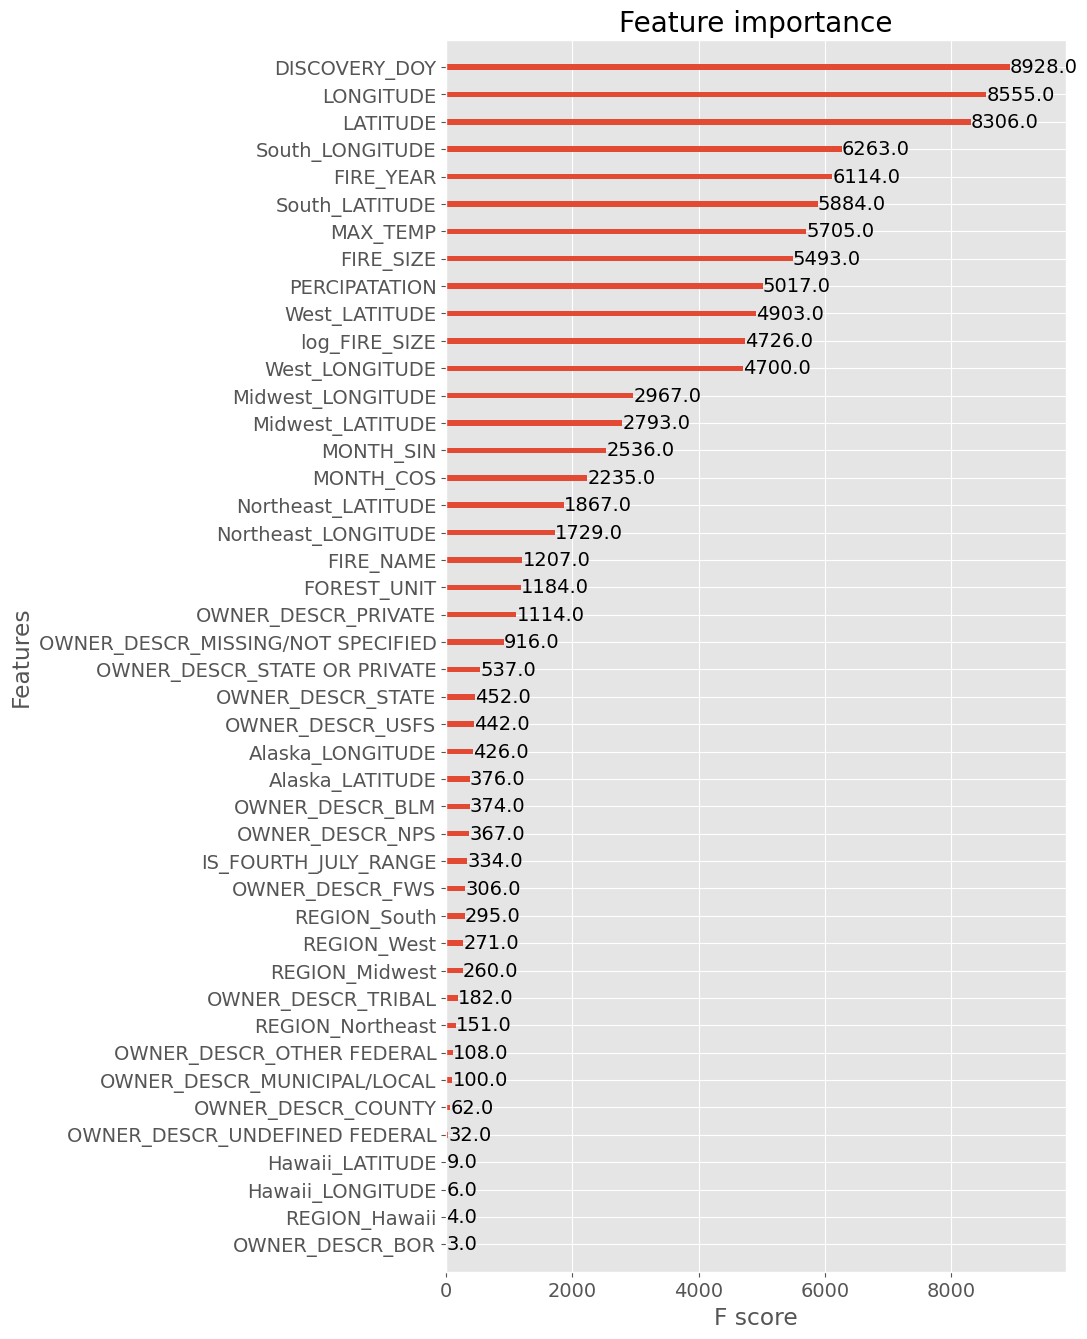

In [22]:
y_pred_p = model.predict_proba(X_test)

print("\nROC AUC Score:")
print(roc_auc_score(y_test, y_pred_p, multi_class='ovr'))

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


plt.figure(figsize=(8, 16))
xgb.plot_importance(model, ax=plt.gca())
plt.show()

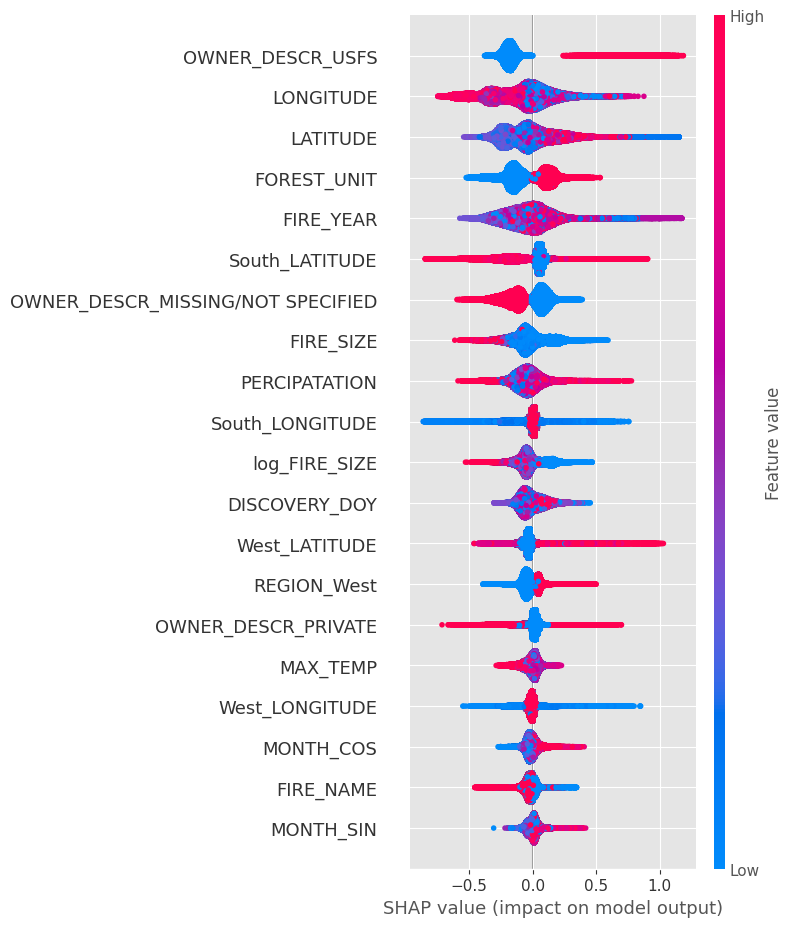

In [23]:
X_shap = X_train
explainer = shap.Explainer(model)
shap_values = explainer.shap_values(X_shap)
shap.initjs()
shap.summary_plot(shap_values[1], X_shap.values, feature_names=X_shap.columns)

# Random Forest

In [24]:
# from sklearn.ensemble import RandomForestClassifier
# def objective(trial):
#     params = {
#         'n_estimators': trial.suggest_int('n_estimators', 10, 80),
#         'max_depth': trial.suggest_int('max_depth', 4, 10),
#         'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
#         'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),
#         'max_features': trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2']),
#     }
# 
#     model = RandomForestClassifier(**params)
#     
#     roc_auc = cross_val_score(model, X_train, y_train, scoring='roc_auc_ovr', cv=4).mean()
# 
#     return roc_auc
# 
# #  parameters: {'n_estimators': 72, 'max_depth': 10, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features'
# # 'log2'}
# 
# study = optuna.create_study(direction='maximize')
# 
# study.optimize(objective, n_trials=10)
# 
# best_params = study.best_params

In [25]:
# # Initialize and train the Random Forest model
# best_model = RandomForestClassifier(**best_params)
# best_model.fit(X_train, y_train)
# 
# y_prob = best_model.predict_proba(X_test)
# 
# # Calculate ROC AUC score
# roc_auc = roc_auc_score(y_test, y_prob, multi_class='ovr')
# print("ROC AUC Score:", roc_auc)
# 
# # Make predictions
# y_pred = best_model.predict(X_test)
# 
# # Evaluate the model
# accuracy = accuracy_score(y_test, y_pred)
# print("Accuracy:", accuracy)
# 
# # Generate classification report and confusion matrix
# print("\nClassification Report:")
# print(classification_report(y_test, y_pred))
# 
# # If needed, you can visualize feature importances
# plt.figure(figsize=(8, 6))
# plt.barh(X_train.columns, best_model.feature_importances_)
# plt.xlabel('Feature Importance')
# plt.ylabel('Feature')
# plt.title('Random Forest Feature Importances')
# plt.show()

In [26]:
# X_shap = X_train.iloc[0:10000]

In [27]:
# explainer = shap.TreeExplainer(best_model)
# shap_values = explainer.shap_values(X_shap)
# shap.initjs()
# shap.summary_plot(shap_values[1], X_shap.values, feature_names=X_shap.columns)